  # Size Distribution Stats

  This example shows how to process size distribution data from an SMPS.
 The processing returns mean properties of the size distribution, such as
 the mean diameter, median diameter, and total PM2.5 mass.

In [3]:
# all the imports
import matplotlib.pyplot as plt
from particula.data import loader_interface, settings_generator
from particula.data.tests.example_data.get_example_data import get_data_folder
from particula.data.loader_setting_builders import (
    # These functions create settings for loading data from files.
    DataChecksBuilder,
    SizerDataReaderBuilder,
    LoaderSizerSettingsBuilder,
)

# the new step
from particula.data.process import size_distribution

# set the parent directory of the data folder
path = get_data_folder()

 ### Load the data

 For this example we'll use the provided example data. But you can change the
 path to any folder on your computer. We then can used the settings generator
 to

 If you think this settings generator is getting tedious, we hear you. We'll
 show the fix to that soon.

In [4]:
# settings for the SMPS data
data_checks_sizer = (
    DataChecksBuilder()
    .set_characters([250])
    .set_skip_rows(25)
    .set_char_counts({"/": 2, ":": 2})
    .build()
)
data_sizer_reader = (
    SizerDataReaderBuilder()
    .set_sizer_start_keyword("20.72")
    .set_sizer_end_keyword("784.39")
    .set_sizer_concentration_convert_from("dw/dlogdp")
    .build()
)
smps_1d_settings, smps_2d_settings = (
    LoaderSizerSettingsBuilder()
    .set_relative_data_folder("SMPS_data")
    .set_filename_regex("*.csv")
    .set_header_row(24)
    .set_data_checks(data_checks_sizer)
    .set_data_column(
        [
            "Lower Size (nm)",
            "Upper Size (nm)",
            "Sample Temp (C)",
            "Sample Pressure (kPa)",
            "Relative Humidity (%)",
            "Median (nm)",
            "Mean (nm)",
            "Geo. Mean (nm)",
            "Mode (nm)",
            "Geo. Std. Dev.",
            "Total Conc. (#/cm³)",
        ]
    )
    .set_data_header(
        [
            "Lower_Size_(nm)",
            "Upper_Size_(nm)",
            "Sample_Temp_(C)",
            "Sample_Pressure_(kPa)",
            "Relative_Humidity_(%)",
            "Median_(nm)",
            "Mean_(nm)",
            "Geo_Mean_(nm)",
            "Mode_(nm)",
            "Geo_Std_Dev.",
            "Total_Conc_(#/cc)",
        ]
    )
    .set_data_sizer_reader(data_sizer_reader)
    .set_time_column([1, 2])
    .set_time_format("%m/%d/%Y %H:%M:%S")
    .set_delimiter(",")
    .set_timezone_identifier("UTC")
    .build()
)

# collect settings into a dictionary
combined_settings = {
    'smps_1d': smps_1d_settings,
    'smps_2d': smps_2d_settings,
}

# now call the loader interface for files
lake = loader_interface.load_folders_interface(
    path=path,
    folder_settings=combined_settings,
)

print(' ')
print(lake)

Folder Settings: smps_1d
  Loading file: 2022-07-07_095151_SMPS.csv
  Loading file: 2022-07-10_094659_SMPS.csv
Folder Settings: smps_2d
  Loading file: 2022-07-07_095151_SMPS.csv
  Loading file: 2022-07-10_094659_SMPS.csv
 
Lake with streams: ['smps_1d', 'smps_2d']


 # Processing the Stream
 The lake is a collection of streams, stored as a dictionary. The next step
 can be average the data or you may have a processing step that you want to
 apply to all the data. For example, you may want to calculate the total
 PM2.5 mass from the SMPS data. You could do this by looping through the
 streams and applying a cusutom processing function to each stream. Or you could
 use some standard process already built in to `particula.data.process`. In this
 example we'll use `process.size_distribution` to calculate the PM2.5 mass from the

In [5]:
lake['mean_properties'] = size_distribution.sizer_mean_properties(
    stream=lake['smps_2d'],
    diameter_units='nm',
)

# list out the header
for header in lake['mean_properties'].header:
    print(header)

Total_Conc_(#/cc)
Mean_Diameter_(nm)
Geometric_Mean_Diameter_(nm)
Mode_Diameter_(nm)
Mean_Diameter_Vol_(nm)
Mode_Diameter_Vol_(nm)
Unit_Mass_(ug/m3)
Mass_(ug/m3)
Total_Conc_(#/cc)_N100
Unit_Mass_(ug/m3)_N100
Mass_(ug/m3)_N100
Total_Conc_(#/cc)_PM1
Unit_Mass_(ug/m3)_PM1
Mass_(ug/m3)_PM1
Total_Conc_(#/cc)_PM2.5
Unit_Mass_(ug/m3)_PM2.5
Mass_(ug/m3)_PM2.5
Total_Conc_(#/cc)_PM10
Unit_Mass_(ug/m3)_PM10
Mass_(ug/m3)_PM10


 # Plot the Data
 With that processing done we can plot some useful summary plots. For example,
 we can plot the total PM2.5 mass as a function of time. And on the same plot
 we can add the N100 mass.
 ### Tip: Calling the header directly
 Note below how we can call the data header directly from the stream. This is
 because the get items property defined in the stream class accepts, either and
 index or a header name. So we can call the header name directly from the
 stream and get back that specific time series.

 This is incontrast to callint `stream.data['header_name']` which would return
 an error. As that line first calls `stream.data` returning the np.ndarray, then calls
 the header name, which is not a valid index for a np.ndarray.

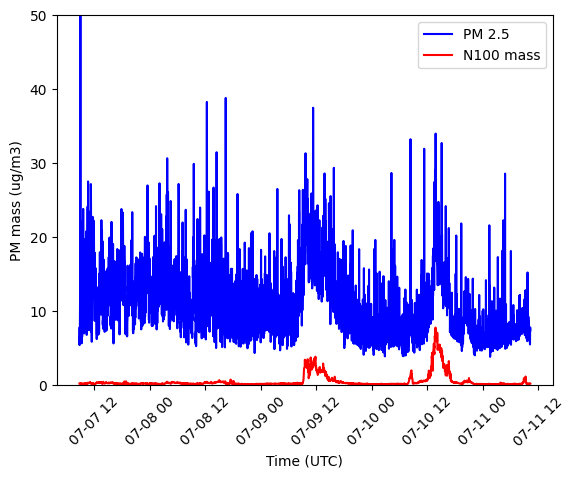

In [6]:
mean_prop_stream = lake['mean_properties']

# plot the data on twinx axis
fig, ax = plt.subplots()
ax.plot(mean_prop_stream.datetime64,
        mean_prop_stream['Mass_(ug/m3)_PM2.5'],
        label='PM 2.5',
        color='blue')
ax.plot(mean_prop_stream.datetime64,
        mean_prop_stream['Mass_(ug/m3)_N100'],
        label='N100 mass',
        color='red')
ax.set_ylim(0, 50)
plt.xticks(rotation=45)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel('PM mass (ug/m3)')
ax.legend()
plt.show()
fig.tight_layout()

 # Summary
 This example showed how to process size distribution data from an SMPS. The
 processing returns mean properties of the size distribution, such as the mean
 diameter, median diameter, and total PM2.5 mass.